# Understanding data maintenance in humanitarian mapping

### 1. Setup

In [1]:
# Load in the relevant libraries 
# install.packages('readr', repos='http://cran.us.r-project.org')
library(dplyr)
library(lubridate)
library(stringr)
library(sf)
library(ggplot2)
library(tidytext)
library(geosphere)
library(ggridges)
library(ggpubr)
library(reshape2)
library(tidyr)
library(data.table)
options(warn=-1)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Linking to GEOS 3.6.1, GDAL 2.2.3, PROJ 4.9.3
Warning message:
"package 'tidytext' was built under R version 3.6.3"Warning message:
"package 'ggridges' was built under R version 3.6.2"Loading required package: magrittr

Attaching package: 'tidyr'

The following object is masked from 'package:reshape2':

    smiths

The following object is masked from 'package:magrittr':

    extract


Attaching package: 'data.table'

The following objects are masked from 'package:reshape2':

    dcast, melt

The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from 'package:dplyr':

    betw

In [2]:
# Define the colour palette for visualizations
black <- '#080F0F'
blue <- '#8941b5'
yellow <- '#EFF2C0'
brown <- '#BEA57D'
red <- '#A52422'
turq <- '#25CED1'
coral <- '#FF8A5B'
pink <- '#EA526F'
green <- '#9BC53D'
grey <- '#b6afba'

In [3]:
# Define global variables relating to the extent of the case study
start <- ''
end <- ''
north <- ''
south <- ''
east <- ''
west <- ''

In [4]:
# Define vector of the case studies 
cases <- c('tac', 'nep', 'pap','car', 'hed')

### 2. Load in the data

- Input = name of the case study
- Output = the dataframe with nodes and ways

In [5]:
load <- function(case){
    
    # Define the directory where the data is located
    dir <- "C:\\Users\\hanna\\Desktop\\Dissertation\\3_Analyzing\\Data\\"
    
    # Read in the case details file and subset appropriately 
    cases <- read.csv(paste0(dir,'case_studies.csv'), quote = "",fill=TRUE, stringsAsFactors=FALSE)
    sel <- cases%>%filter(Location == case)

    # Get the case-specific variables
    start <<- sel[[7]]
    end <<- sel[[8]]
    north <<- sel[[3]]
    south <<- sel[[4]]
    east <<- sel[[5]]
    west <<- sel[[6]]
    
    # Read in the appropriate data
    path_node <- paste0(dir, case, '-nodes.csv')
    path_way <- paste0(dir, case, '-ways.csv')

    data_node <- fread(path_node, header=TRUE, sep=",", fill=TRUE)
    data_way <- fread(path_way, header=TRUE, sep=",", fill=TRUE)

    # Join the nodes and ways data
    data <- rbind(data_node, data_way)
    
    # Return the dataframe
    return(data)
}

### 3. Clean the data

- Input = 'raw' read data from the load function
- Output = cleaned dataframe

In [6]:
clean <- function(data){
    
    # Clean and transform some columns 
    data <- data %>% 
        mutate(OSH_ID = as.numeric(OSH_ID))%>% # Convert to numeric type
        mutate(OSM_TME = as.Date(ymd_hms(OSM_TME)))%>% # Format the time more simply
        mutate(OSH_BB_a = as.numeric(substring(OSH_BB_a, 2)))%>% # Clean up the coordinates columns
        mutate(OSH_BB_b = as.numeric(OSH_BB_b))%>% # Convert data types
        mutate(OSH_BB_c = as.numeric(OSH_BB_c))%>% # Convert data types
        mutate(OSH_BB_d = as.numeric(substring(OSH_BB_d,1,nchar(as.character(OSH_BB_d))-1)))%>% # Clean coordinate data
        filter(OSM_TME >= as.Date(start)) # Convert to date format
    
    return(data)
}

### 4. Basic characteristics of the mapping activation

- Input = cleaned dataframe
- Output = dataframe with summary statistics

In [7]:
analyze <- function(data){
    
    # Filtering to answer some basic questions

    # --- How many creations over the mapping activation?
    tot_create <- nrow(data %>% filter(OSM_VER == 1))

    # --- How many unique contributors over the mapping activation?
    tot_contrib <- nrow(data %>% filter(OSM_VER == 1) %>% distinct(OSM_UID))

    # --- How many unique changesets over the mapping activation?
    tot_change <- nrow(data %>% filter(OSM_VER == 1) %>% distinct(OSM_CHG))

    # --- How many contributions have been updated following the mapping activation? 
    tot_mod <- nrow(data %>% 
        filter(OSM_TME > end) %>% # Only get the edits made after the end of the activation
        group_by(OSH_ID)%>% # Group by OSH ID
        summarise(MAX_VER = max(OSM_VER))) # Get the maximum version of each OSHEntity

    # -- What percent of nodes and ways created during the activation have since been modified?
    per_mod <- tot_mod/tot_create*100 # Percent of contributions that were modified

    # --- How many days did it take for half of all contributions to be made?
    arranged <- data %>% arrange(OSM_TME)%>% filter(OSM_VER == 1) # Arrange by date and make sure only new contributions
    burst <- as.numeric(as.period(as.Date(start)%--%as.Date(arranged['OSM_TME'][tot_create/2,])), 'day')  

    # --- Is this activation an event or a mission?
    style <- ''
    if(burst<=60){style='event'}
    if(burst>60){style='mission'}

    # --- What is the total duration of the activation?
    dur <- as.numeric(as.period(as.Date(start)%--%as.Date(end)), 'day')  

    # --- What is the size of this study area?
    poly <- data.frame( # Create as dataframe 
      lon = c(east, west, west, east),
      lat = c(north, north, south, south)
    )
    area <- areaPolygon(poly)/1000000 # Calculate the area in sq m
    
    # Write the results to a dataframe
    output_data <- data.frame(
        'Created'= tot_create,
        'Contrib'= tot_contrib,
        'Changesets'=tot_change,
        'Modified_after'=tot_mod,
        'Per_maint'=per_mod,
        'Burst'=burst,
        'Style'=style,
        'Duration'=dur,
        'Area'=area
    )
    
    return(output_data)
    
}

### 5. Parse the tags

- Input = the cleaned dataframe
- Output = dataframe with the most frequently occurring tags

In [8]:
tag_parse <- function(data){
    
    # Get only the newly created data
    text_df <- data %>% filter(OSM_VER == 1)
    text_df <- tibble(text_df$OSM_KYS)
    
    # Get the total number of new contributions from the data
    tot_create <- nrow(data %>% filter(OSM_VER == 1))
    
    # Get the most frequently occurring keys
    text <- text_df %>%
        unnest_tokens(word, `text_df$OSM_KYS`)%>%
        count(word, sort = TRUE)%>%
        mutate(percent = n/tot_create*100)%>%
        mutate(word = reorder(word, percent))%>%
        top_n(10, percent)
    
    return(text)
}

- Input: the cleaned dataframe
- Output: dataframe with top 10 most frequently occurring sources

In [9]:
getSources <- function(data){
    
    # Get the tags from all unique OSM entities
    tags <- data %>% filter(OSM_VER == 1)%>%select(OSM_TGS)
    
    # Loop through all data to get the values that are associated with the source key
    tags_list <- c()
    for(i in 1:nrow(tags)){
        if(str_detect(tags[i,], 'source')){
            a <- str_match(tags[i,], "source:geometry=s*(.*?)$")[,2]
            b <- ((strsplit(a, '@')[[1]][1]))
            tags_list <- c(tags_list, b)
        }
    }

    # Create in tibble format
    text <- tibble(tags_list)
    
    # Get the total number of new contributions from the data
    tot_create <- nrow(data %>% filter(OSM_VER == 1))

    # Organize to get the most frequently occurring tags 
    top_sources <- text %>%
        mutate(tags_list = tolower(tags_list))%>%
        count(tags_list, sort = TRUE)%>%
        mutate(word_per = n/tot_create*100)%>%
        mutate(word = reorder(tags_list, word_per))%>%
        top_n(10, word_per)

    return(top_sources)
}

### 6. Time series of daily mapping activity

- Input = the cleaned dataframe
- Output = dataframe with daily unique contributors and daily contributions

In [10]:
activity <- function(data){
    # Create plots of the time series of contributions 

    # --- Show me the daily contributions over the activation period
    daily_adds <- data %>%
        filter(OSM_VER == 1)%>%
        group_by(Date = OSM_TME)%>% 
        summarise(Count = n())

    # --- Show me the daily contributors over the activation period? 
    daily_users <- data %>%
        filter(OSM_VER == 1)%>%
        group_by(Date = OSM_TME)%>% 
        summarize(Unique = n_distinct(OSM_UID))
    
    # --- Add the day column
    daily_users$Day <- seq.int(nrow(daily_users))
    daily_adds$Day <- seq.int(nrow(daily_adds))
    
    # --- Join the two
    joined <- inner_join(daily_users, daily_adds, by='Date')
    
    return(joined)

}

### 7. Density of contributions over space

- Input = the cleaned dataframe
- Output = hexbin map of the density of contributions 

In [11]:
# Helper - Called inside of the 'map' function

getCoord <- function(north_, south_, east_, west_, type, coord){
    
    # If it's a node then just return one of the existing coords 
    if(type=='NODE'){
        if(coord=='lon'){
            return(east_)
        }
        if(coord=='lat'){
            return(north_)
        }
    }
    # If it's a way then we need to calculate the centroid of the bbox
    if(type=='WAY'){
      box <- list(matrix(c(
                north_, east_, 
                north_, west_, 
                south_, west_, 
                south_, east_, 
                north_, east_), ncol=2, byrow=TRUE))
        point <- st_coordinates(st_centroid(st_polygon(box)))

        if(coord=='lon'){
            return(point[2])
        }
        if(coord=='lat'){
            return(point[1])
        }       
    } 
}

In [12]:
# Helper - Called inside of the 'map' function
centroid <- function(data){
    
    # Create a dataframe that has Lat/Lon column that corresponds to the centroid of the entity
    wcoords <- data %>% 
        rowwise() %>%
        mutate(Lon = getCoord(OSH_BB_a, OSH_BB_c, OSH_BB_b, OSH_BB_d, OSH_TYP, 'lat'))%>%
        mutate(Lat = getCoord(OSH_BB_a, OSH_BB_c, OSH_BB_b, OSH_BB_d, OSH_TYP, 'lon'))
    
    return(wcoords)
}

In [13]:
# Helper - write data to shapefile 
write_shp <- function(wcoords, case){
    
    # Get only the newly created data
    wcoords_sel <- wcoords %>% filter(OSM_VER == 1)
    
    # --- Define the CRS
    projcrs <- "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"

    # --- Create sf object 
    data_geom <- st_as_sf(x = wcoords_sel,                         
               coords = c("Lon", "Lat"),
               crs = projcrs)

    # --- Remove the unneeded columns 
    #data_geom <- data_geom %>% select(c(1,2,7,8,9,10,11,12))
    
    # Write to shp 
    dir = 'C:\\Users\\hanna\\Desktop\\Dissertation\\3_Analyzing\\Results\\'
    st_write(data_geom, paste0(dir,case,'.shp'))
}

In [14]:
map <- function(data){
    
    # Create the dataframe with the coordinates 
    wcoords <- centroid(data) 
    
    # Select to get only the newly created data
    wcoords_sel <- wcoords %>% filter(OSM_VER == 1)
    
    # Read sf object of the basemap area
    shp <- readRDS(paste0(case, '.rds'))
    
    # Create the ggplot map
    map <- ggplot(data=shp) +
        geom_sf() +
        coord_sf(xlim = c(west, east), ylim = c(north, south), expand = FALSE)+
        theme_void()+
        geom_hex(data=wcoords_sel, aes(x=Lon, y=Lat), bins=80, alpha = 0.6)+
        scale_fill_gradient(low = yellow,
              high = red)+
        theme(legend.position="bottom",
             legend.title = element_blank())

    return(map)
    
}

### 8. Understanding data maintenance

- Input = the cleaned dataframe
- Output = dataframe with the cumulative percent of features modified at least once over time

In [15]:
ratio <- function(data){
    
    # The years to loop through
    years <- c(0,1,2,3,4)
    maint_time <- c()
    
    # Get the total number of new contributions from the data
    tot_create <- nrow(data %>% filter(OSM_VER == 1))

    # Loop through all years 
    for(year in years){

        st <- as.Date(end) # Start time 
        nd <- as.Date(end) %m+% years(year) # End time 

        sel <- data %>% filter(OSM_TME>st & OSM_TME<nd)%>% # Only get the edits made within time of interest
        group_by(OSH_ID)%>% # Group by OSH ID
        summarise(MAX_VER = max(OSM_VER)) # Get the max version
        per <- nrow(sel)/tot_create*100 # Get the percent maintenance for that time period
        maint_time <- c(maint_time, per)

    }

    # Create the dataframe to return
    maint_time <- data.frame('Years'=c(years), 'Maint_per'=c(maint_time))
    
    # Return the dataframe
    return(maint_time)
}

- Input = the cleaned dataframe
- Output = dataframe with the max version for all entities at yearly intervals

In [16]:
mver <- function(data){
    
    # Years to loop through and the empty dataframe
    years <- c(0,1,2,3,4)
    max_ver <- data.frame('Year'=c(), 'MV'=c())
    
    # Loop through all years 
    for(year in years){

        nd <- as.Date(end) %m+% years(year) # End time 
        sel <- data %>% filter(OSM_TME<nd)%>% # Only get the edits made within time of interest
        group_by(OSH_ID)%>% # Group by OSH ID
        summarise(MAX_VER = max(OSM_VER)) # Get the max version
        
        # Iteratively add to the output dataframe with each loop
        x <- data.frame('Year'=rep(year, nrow(sel)), 'MV'=sel$MAX_VER)
        max_ver <- rbind(max_ver, x)

    }
    
    # Convert the years to factors 
    max_ver <- max_ver %>% mutate(Year=as.factor(Year))
    
    # Return the dataframe
    return(max_ver)
}

- Input = the cleaned dataframe
- Output = dataframe with volume of entities by maintenance frequency category, cumulatively for years 1-4 after the activation

In [17]:
maintFreq <- function(data){

    # Years to loop through
    times <- c(1,2,3,4)

    # Output dataframe
    output <- data.frame('Class'=c(), 'Percent'=c(), 'Year'=c())

    #Loop through all of the years 
    for(year in times){

        # Get the edits that were made after the activation ended but before 4 years have passed 
        # Count the number of times that each entity appears - this corresponds to the number of times that it has been revised
        filtered <- data %>% 
        filter(OSM_TME > as.Date(end) & OSM_TME < (as.Date(end) %m+% years(year))) %>%
        count(OSH_ID)

        # Count the number of entities with each maintenance frequency
        counted <- filtered %>% count(n)

        # Add count of unmaintained data to the dataframe 
        total_edits <- nrow(filter(data, OSM_VER==1)) # Get total number of new edits for the activation
        total_maint <- nrow(filtered) # Get total number of edits that have been maintained at least once 
        total_unmaint <- total_edits - total_maint # Get the total number of unmaintained edits 
        a <- data.frame('n'= 0, 'nn'= total_unmaint) # Create a row with number of unmaintained edits
        counted <- rbind(counted, a) # Add this to the output row 

        # Convert counts to percent of totals and arrange in order 
        counted <- counted %>% 
            mutate(Percent = nn/total_edits*100) %>%
            arrange(n)

        # Classify into categories and group by category
        categorized <- counted %>%
            mutate(Class = case_when(n==0 ~ 'Never', 
                                     n==1~'Once',
                                     n>1 & n<10~'Moderate',
                                     n>=10 & n<19~'Frequent',
                                     n>=19 ~'Extreme')) %>%
            group_by(Class)%>%
            summarize(Percent = sum(Percent)) %>%
            mutate(Year = year)

        # Bind with the output data
        output <- rbind(output, categorized)
    }
    return(output)
}

- Input = the cleaned dataframe
- Output = dataframe with the count of nodes and ways for different breaks of max version - up until 4 years after the activation

In [18]:
maintType <- function(data){
    
   # only unique OSH IDs 
    unique <- data %>% filter(OSM_VER==1)

    # Filter the times and count number of versions between these times
    filtered <- data %>% 
            filter(OSM_TME > as.Date(end) & OSM_TME < (as.Date(end) %m+% years(4))) %>%
            count(OSH_ID)

    # Join with other relevant columns 
    # And calculate new columns to understand the tags' characteristics 
    # Add an 'other' column to identify features that are neither buildings nor roads
    info <- filtered %>% 
        full_join(unique, by='OSH_ID') %>%
        select(c(1,2,3,12))%>%
        mutate(n = replace_na(n, 0)) %>%
        mutate(Highway = grepl('highway', OSM_KYS), 
               Building = grepl('building', OSM_KYS),
               Amenity = grepl('amenity', OSM_KYS),
               NumTags = (str_count(OSM_KYS, '@'))+1)%>%
        mutate(Other = ifelse((Highway==FALSE & Building==FALSE), TRUE, FALSE))

    # Count the number of features with the same version numbers 
    counted <- info %>% count(n)

    # Get the count of highways,buildings, other, nodes, and ways by maintenance frequency category 
    highways <- info %>% group_by(n) %>% count(Highway) %>% filter(Highway==TRUE)
    buildings <- info %>% group_by(n) %>% count(Building) %>% filter(Building==TRUE)
    other <- info %>% group_by(n) %>% count(Other) %>% filter(Other==TRUE)
    nodes <- info %>% group_by(n) %>% count(OSH_TYP) %>% filter(OSH_TYP=='NODE')
    ways <- info %>% group_by(n) %>% count(OSH_TYP) %>% filter(OSH_TYP=='WAY')

    # Join the columns 
    joined <- counted %>%
        full_join(highways, by='n') %>%
        full_join(buildings, by='n') %>%
        full_join(other, by='n') %>%
        full_join(nodes, by='n') %>%
        full_join(ways, by='n') %>%
        select(1,2,4,6,8,10,12)

    # Create new column names 
    colnames(joined) <- c('n', 'Total', 'Highways', 'Buildings', 'Other', 'Nodes', 'Ways')

    # Replace na with zero
    joined[is.na(joined)] = 0

    # Classify into categories and group by category
    categorized <- joined %>%
        mutate(Class = case_when(n==0 ~ 'Never', 
                                 n==1~'Once',
                                 n>1 & n<10~'Moderate',
                                 n>=10 & n<19~'Frequent',
                                 n>=19 ~'Extreme'))%>%
        group_by(Class)%>%
        summarize_all(sum)%>%
        mutate(Class=factor(Class, levels=c('Extreme', 'Frequent','Moderate','Once','Never')))
    
    # Convert to percents of total
    percents <- categorized %>% mutate(Highways = Highways/sum(Highways)*100,
                                   Buildings = Buildings/sum(Buildings)*100,
                                   Other = Other/sum(Other)*100,
                                   Ways = Ways/sum(Ways)*100,
                                   Nodes = Nodes/sum(Nodes)*100)
    
    return(percents)
    
}

### 9. Running the functions

In [19]:
# Read in, clean, and summarize all the data 
for(case in cases){
    
    # Variable names - eg. tac_data, tac_analyzed
    data_name <- paste0(case, '_data')
    analyzed_name <- paste0(case, '_analyzed')
    activity_name <- paste0(case, '_activity')
    ratio_name <- paste0(case, '_mr')
    mver_name <- paste0(case, '_mv')
    tag_name <- paste0(case, '_tag')
    type_name <- paste0(case, '_type')
    map_name <- paste0(case, '_map.png')
    source_name <- paste0(case, '_source')
    geog_name <- paste0(case, '_geog')
    
    # Read the data
    data <- clean(load(case))
    
    # Analyze the data
    analyzed <- analyze(data)
    analyzed$Case <- case
    
    # Get the daily activity for the data 
    daily <- activity(data)
    daily$Case <- case
    
    # Get the maintenance 
    mr <- ratio(data)
    mr$Case <- case
    mv <- maintFreq(data)
    mv$Case <- case
    
    # Get the tags
    tags <- tag_parse(data)
    tags$Case <- case
    
    # Create the map of contributions 
    #coords <- centroid(data)
    #write_shp(coords, case)
    #map_ <- map(data)
    #ggsave(map_name, width=4, height=4, units='in')
    
    # Get the sources
    sources <- getSources(data)
    sources$Case <- case
    
    # Get the breakdown of overall maintenance by type
    types <- maintType(data)
    types$Case <- case
    
    # Assign to variables for reuse
    assign(data_name, data)
    assign(analyzed_name, analyzed)
    assign(activity_name, daily)
    assign(ratio_name, mr)
    assign(mver_name, mv)
    assign(tag_name, tags)
    assign(type_name, types)
    assign(source_name, sources)
    #assign(geog_name, coords)
    
}

In [20]:
# Total number of rows 
nrow(tac_data) + nrow(hed_data) + nrow(car_data) + nrow(pap_data) + nrow(nep_data)

[1] 495891

In [21]:
# Create custom ggplot theme
# https://rpubs.com/mclaire19/ggplot2-custom-themes

theme_gppr <- function(){ 
    font <- "serif"   #assign font family up front
    
    theme_minimal() %+replace%    #replace elements we want to change
    
    theme(
      
      #text elements
     
      axis.title = element_text(             #axis titles
                   family = font,            #font family
                   size = 18),               #font size
      
      axis.text = element_text(              #axis text
                   family = font,            #axis famuly
                   size = 14),                #font size
      
      axis.text.x = element_text(            #margin for axis text
                    margin=margin(5, b = 10)),
        
     legend.text=element_text(
                     size=14, 
                     family=font),
        
      legend.position="bottom",
      legend.title = element_blank(),
      strip.text.x = element_text(size = 14)
    )
}

# What are the basic characteristics of each mapping activation?

In [22]:
# Combine all of the analysis
analysis_summary <- rbind(tac_analyzed, nep_analyzed, hed_analyzed, pap_analyzed, car_analyzed)
analysis_summary

write.csv(analysis_summary, 'analysis_summary.csv')

Created,Contrib,Changesets,Modified_after,Per_maint,Burst,Style,Duration,Area,Case
19801,199,1144,1684,8.504621,1.0000,event,81.8750,356.27605,tac
37587,881,5151,11821,31.449703,5.0000,event,249.5000,97.92895,nep
5931,133,933,5141,86.680155,164.1875,mission,365.2500,191.98917,hed
76458,368,6344,40596,53.095817,20.0000,event,658.1875,1396.76203,pap
36788,170,1394,5163,14.034468,164.1875,mission,1012.4375,203.21739,car


# How has the data been contributed over time?

In [23]:
# Combine all of the activity data
all_activity <- rbind(tac_activity, nep_activity, hed_activity, pap_activity, car_activity)

all_activity <- all_activity %>% 
    mutate(Case = factor(Case, levels=c('hed','pap', 'car', 'tac','nep'))) %>%
    mutate(Case=recode(Case, 
                         `hed`="Heidelberg",
                         `pap`="Port au Prince",
                          `car`="Bangui",
                          `tac`='Tacloban',
                          `nep`="Kathmandu"))

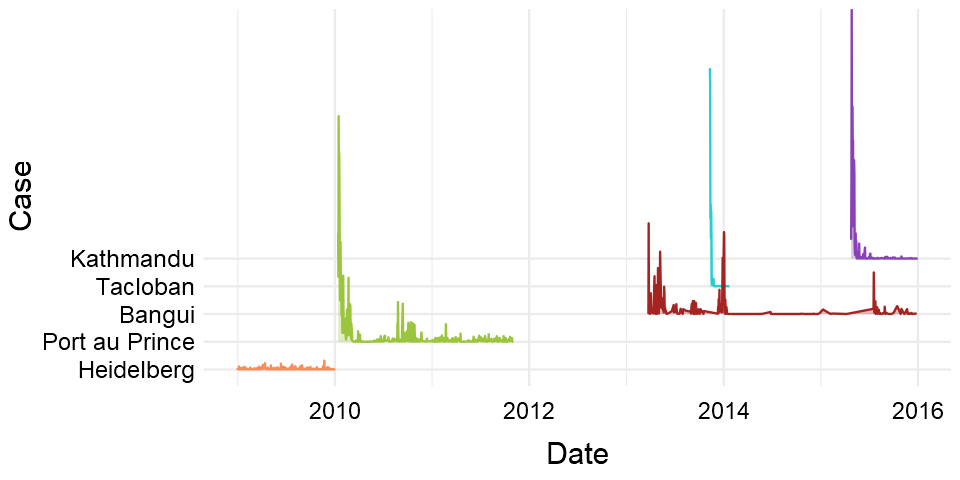

In [24]:
# Plot formatting
options(repr.plot.width=8, repr.plot.height=4)

# Make the plot 
ggplot(all_activity, aes(Date, Case, height = Count, group = Case)) + 
  geom_density_ridges(stat = "identity", scale = 9, alpha=0.3, aes(fill=Case, col=Case))+
    theme_gppr()+
    scale_fill_manual(values = c(coral, green,red, turq, blue))+
    scale_color_manual(values = c(coral, green,red, turq, blue))+
    theme(text=element_text(family="serif"))+
    theme(legend.position = "none")

ggsave('overtime.png', width=8, height=6, units='in')

# How do the daily contributors and daily contributions relate to each other?

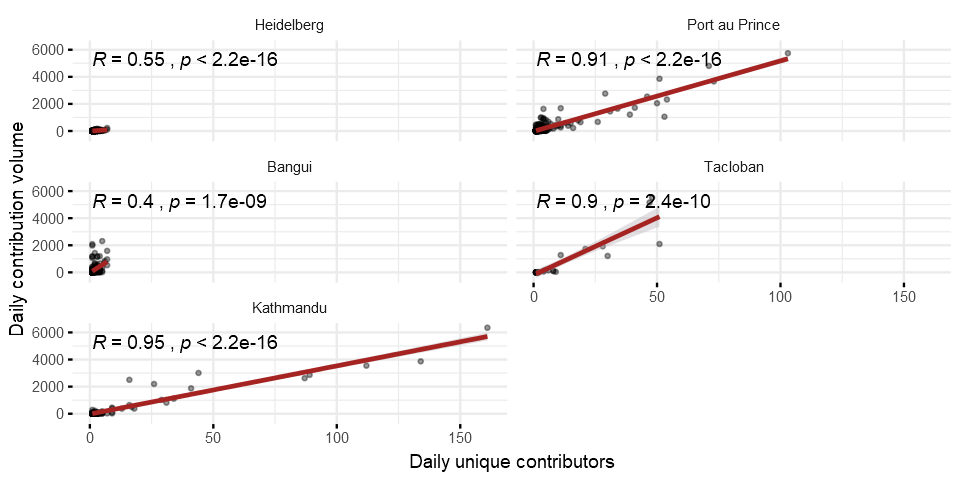

In [25]:
# Create scatter plot 
p <- ggscatter(all_activity, x = "Unique", y = "Count",
          facet.by = c('Case'),
          ncol=2,
          #scales='free',
          size = 0.8, alpha = 0.4,
          add = "reg.line", conf.int = TRUE, 
          add.params = list(color = red,
                            fill = grey),
          ggtheme = theme_minimal(),
          cor.coef = TRUE, cor.method = "pearson",
          xlab = "Daily unique contributors", ylab = "Daily contribution volume")

ggpar(p, 
      font.family = c('serif'))

ggsave('scatter.png', width=6, height=6, units='in')

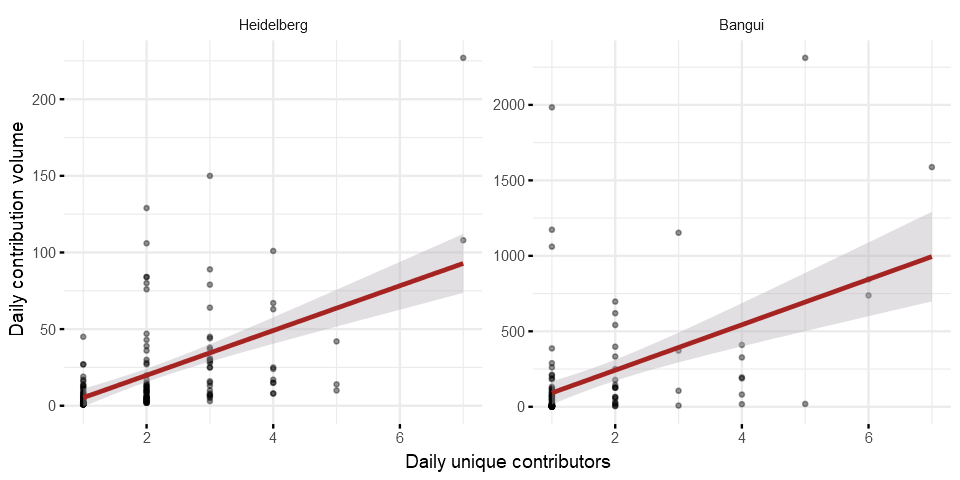

In [26]:
# Create the inset map

sel_activity <- all_activity %>%
    filter(Case==c("Heidelberg", "Bangui"))

p <- ggscatter(sel_activity, x = "Unique", y = "Count",
          facet.by = c('Case'),
          ncol=2,
          scales='free',
          size = 0.8, alpha = 0.4,
          add = "reg.line", conf.int = TRUE, 
          add.params = list(color = red,
                            fill = grey),
          ggtheme = theme_minimal(),
          cor.coef = FALSE, 
          xlab = "Daily unique contributors", ylab = "Daily contribution volume")

ggpar(p, 
      font.family = c('serif'))

ggsave('scatter_sub.png', width=6, height=2, units='in')

# What data is contributed?

In [27]:
all_tags <- rbind(tac_tag, nep_tag, hed_tag, pap_tag, car_tag)
head(all_tags)

write.csv(all_tags, 'alltags.csv')

word,n,percent,Case
building,17738,89.581334,tac
source,5306,26.796626,tac
typhoon:damage,2176,10.989344,tac
highway,525,2.651381,tac
typhoon:damaged,305,1.540326,tac
name,286,1.444371,tac


# What are the sources of this data?

In [28]:
all_sources <- rbind(tac_source, nep_source, hed_source, pap_source, car_source)
head(all_sources)

write.csv(all_sources, 'allsources_geom.csv')

tags_list,n,word_per,word,Case
NA,5298,26.75622443,NA,tac
bing,23,0.11615575,bing,tac
NA,8970,23.86463405,NA,nep
NA,114,1.92210420,NA,hed
NA,61179,80.01647964,NA,pap
bing,12,0.01569489,bing,pap


# How does maintenance occur over time?

In [29]:
all_mr <- rbind(tac_mr, nep_mr, hed_mr, pap_mr, car_mr)
all_mr <- all_mr %>% 
    mutate(Case = factor(Case, levels=c('hed','pap', 'car', 'tac','nep'))) %>%
    mutate(Case=recode(Case, 
                         `hed`="Heidelberg",
                         `pap`="Port au Prince",
                          `car`="Bangui",
                          `tac`='Tacloban',
                          `nep`="Kathmandu"))
head(all_mr, 1)

Years,Maint_per,Case
0,0,Tacloban


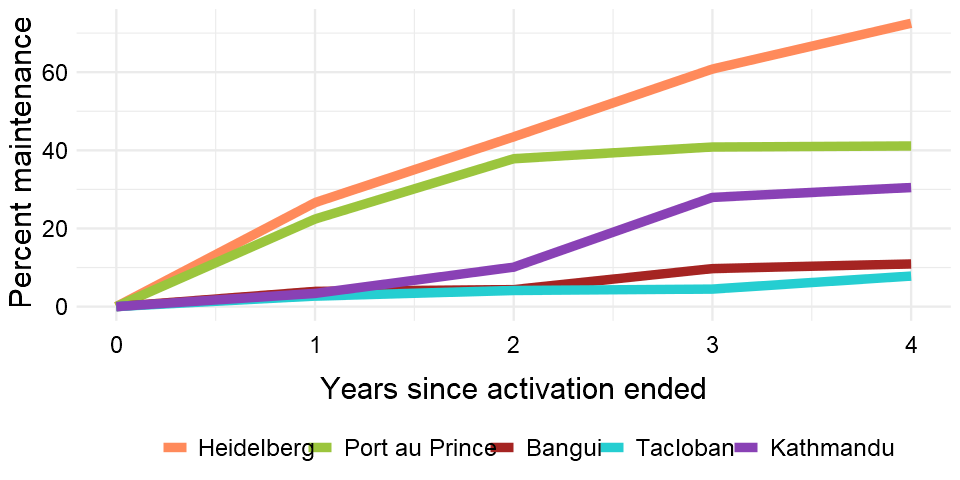

In [30]:
ggplot(all_mr, aes(x=Years, y=Maint_per, group=Case, color=Case)) +
    geom_line(size=2)+
    theme_gppr()+
    labs(x='Years since activation ended', y='Percent maintenance')+
    scale_fill_manual(values = c(coral, green,red, turq, blue))+
    scale_color_manual(values = c(coral, green,red, turq, blue))

ggsave('totmaint.png', width=8, height=6, units='in')

In [31]:
all_mv <- rbind(tac_mv, nep_mv, hed_mv, pap_mv, car_mv)
head(all_mv, 1)

# Create selected version with no versions after 20
all_mv_sel <- all_mv %>% 
    #filter(MV<21) %>%
    mutate(Case = factor(Case, levels=c('hed','pap', 'car', 'tac','nep'))) %>%
    mutate(Case=recode(Case, 
                         `hed`="Heidelberg",
                         `pap`="Port au Prince",
                          `car`="Bangui",
                          `tac`='Tacloban',
                          `nep`="Kathmandu"),
           Class=factor(Class, levels=c('Extreme', 'Frequent','Moderate','Once','Never')))

Class,Percent,Year,Case
Moderate,0.222211,1,tac


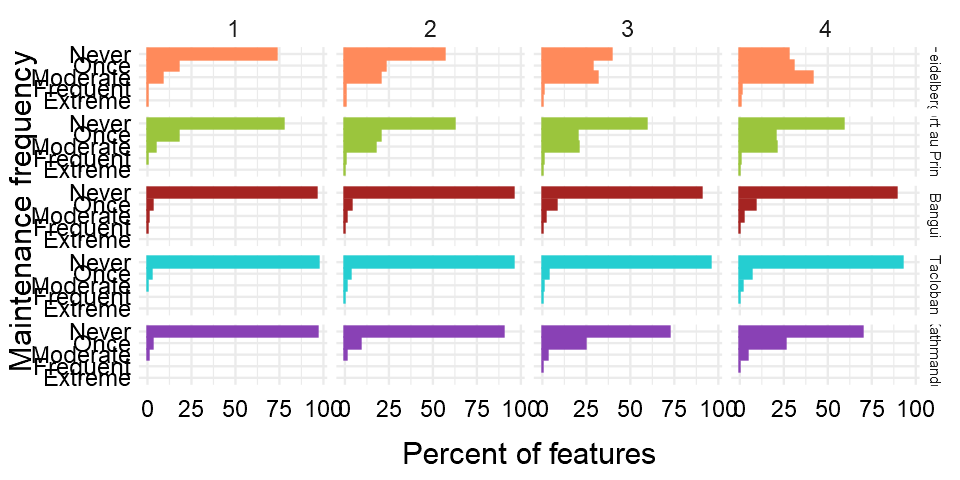

In [32]:
ggplot(all_mv_sel, aes(x=Class, y=Percent, color=Case, fill=Case)) + 
    geom_bar(stat='identity') + 
    facet_grid(Case~Year) + 
    coord_flip()+
    theme_gppr()+
    labs(x='Maintenance frequency', y='Percent of features')+
    scale_fill_manual(values = c(coral, green,red, turq, blue))+
    scale_color_manual(values = c(coral, green,red, turq, blue))+
    theme(text=element_text(family="serif"))+
    theme(legend.position = "none")

ggsave('facetmaint.png', width=8, height=7, units='in')

# What data is maintained?

In [33]:
all_type <- rbind(tac_type, nep_type, hed_type, pap_type, car_type)

all_type <- all_type %>% mutate(Case = factor(Case, levels=c('hed','pap', 'car', 'tac','nep'))) %>%
    mutate(Case=recode(Case, 
                         `hed`="Heidelberg",
                         `pap`="Port au Prince",
                          `car`="Bangui",
                          `tac`='Tacloban',
                          `nep`="Kathmandu"))

head(all_type, 1)

Class,n,Total,Highways,Buildings,Other,Nodes,Ways,Case
Frequent,13,1,0.1904762,0,0,0,0.005192917,Tacloban


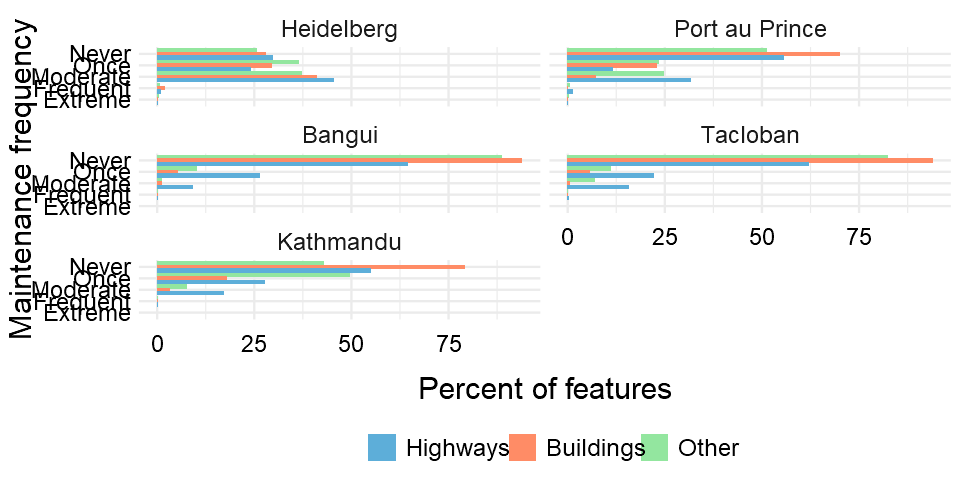

In [34]:
# Look at the difference between highways, buildings, and other
features <- all_type %>% 
    select(1,4,5,6, 9) %>% # Select the right columns
    melt(id.vars=c('Class', 'Case'))# melt for ggplot

ggplot(features, aes(y=value, x=Class, fill=variable)) + 
    geom_bar(position='dodge', stat='identity')+
    facet_wrap(~Case, ncol=2)+
    theme_gppr()+
    scale_fill_manual(values=c("#5daed9", "#ff8c66",'#93e69f'))+
    labs(y='Percent of features', x='Maintenance frequency')+
    coord_flip()

ggsave('featmaint.png', width=8, height=6, units='in')

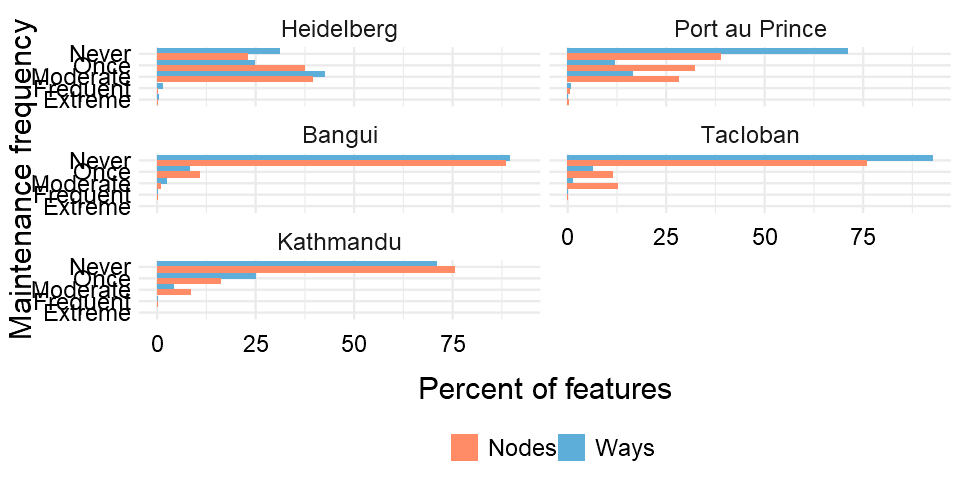

In [35]:
# Look at the difference between nodes and ways
features <- all_type %>% 
    select(1,7,8, 9) %>% # Select the right columns
    melt(id.vars=c('Class', 'Case'))# melt for ggplot

ggplot(features, aes(y=value, x=Class, fill=variable)) + 
    geom_bar(position="dodge", stat="identity")+
    facet_wrap(~Case, ncol=2)+
    theme_gppr()+
    scale_fill_manual(values=c("#ff8c66", "#5daed9", '#6cf580'))+
    labs(y='Percent of features', x='Maintenance frequency')+
    coord_flip()

ggsave('typesmaint.png', width=8, height=6, units='in')